In [46]:
from google.colab import drive
import os
from matplotlib import pyplot as plt
import pandas as pd
import random
import cv2
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from textwrap import wrap

In [4]:
#!pip install transformers datasets evaluate -q
#!pip install jiwer -q

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
base_path = '/content/drive/MyDrive/Flikr_dataset'
img_path = os.path.join(base_path, 'Images')
img_file_names = os.listdir(img_path)
img_file_dir = [os.path.join(img_path, file_name) for file_name in img_file_names]

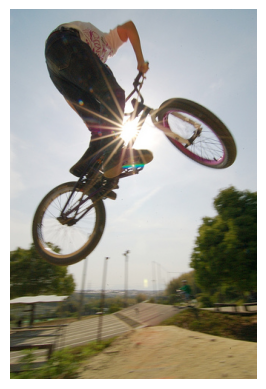

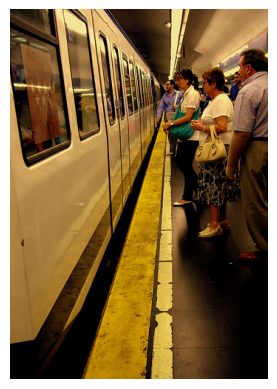

In [7]:
for i,img in enumerate(random.sample(img_file_dir, 2)):
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [8]:
df_captions = pd.read_csv('/content/drive/MyDrive/Flikr_dataset/captions.txt', sep=',', header=0)
df_captions

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [9]:
print("Number of samples:", len(df_captions))
print("Number of unique image IDs:", df_captions["image"].nunique())
df_captions["caption"] = df_captions["caption"].apply(lambda x: x.lower())
print("Number of unique captions:", df_captions["caption"].nunique())

Number of samples: 40455
Number of unique image IDs: 8091
Number of unique captions: 40170


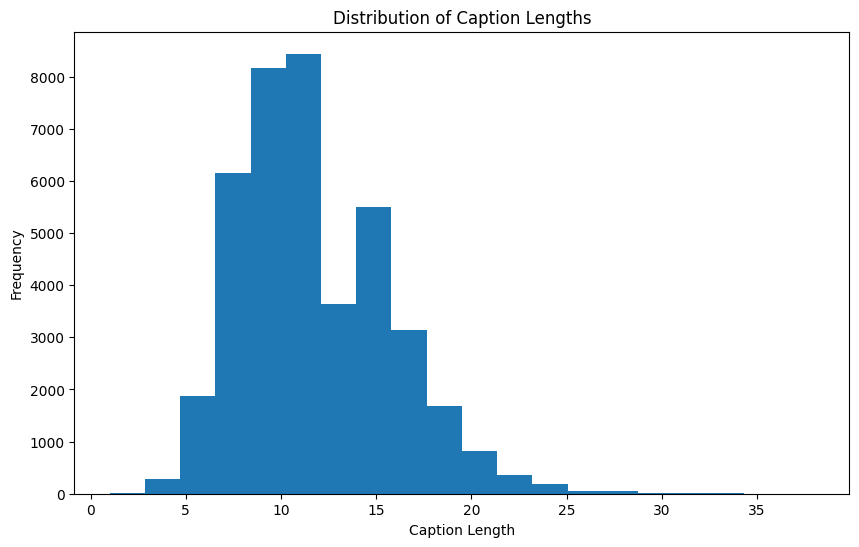

In [10]:
length_captions = df_captions['caption'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(length_captions, bins=20)
plt.title('Distribution of Caption Lengths')
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()

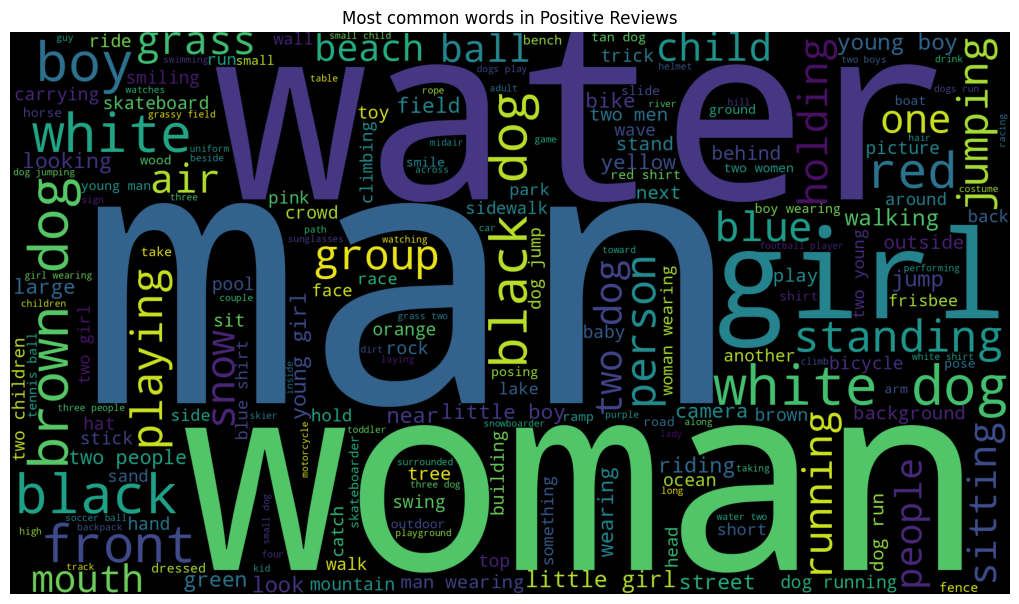

In [11]:
wordcloud = WordCloud(width=1920,height=1080).generate(" ".join(df_captions.caption))
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Most common words in Positive Reviews')
plt.show()

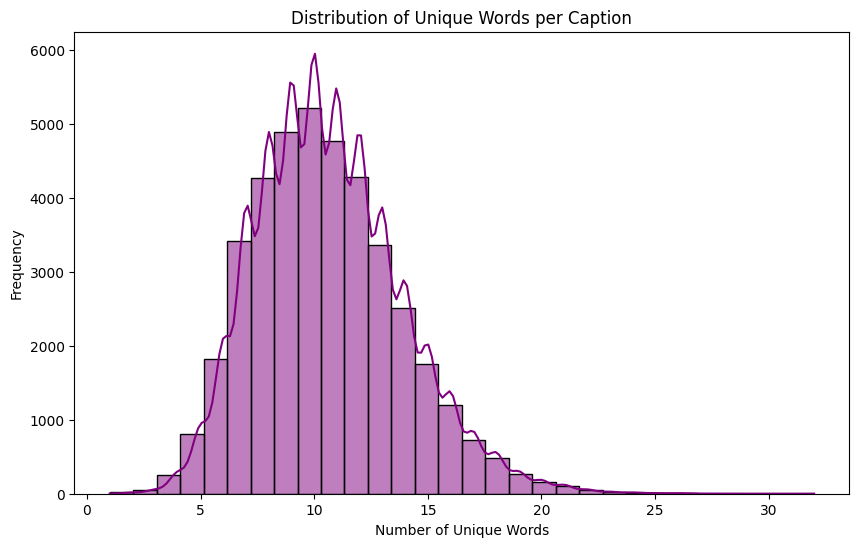

In [12]:
unique_words_per_caption = [len(set(caption.split())) for caption in df_captions['caption']]

plt.figure(figsize=(10, 6))
sns.histplot(unique_words_per_caption, bins=30, kde=True, color='purple')
plt.title('Distribution of Unique Words per Caption')
plt.xlabel('Number of Unique Words')
plt.ylabel('Frequency')
plt.show()

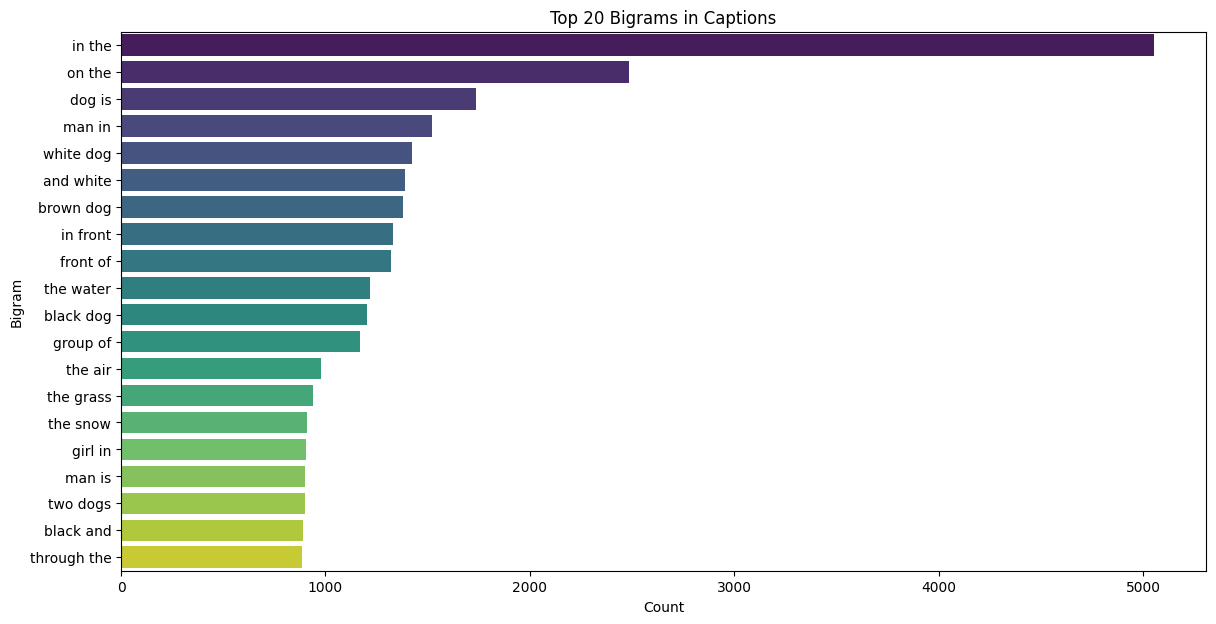

In [13]:
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(df_captions['caption'])

bigram_counts = X.sum(axis=0).A1
bigram_features = vectorizer.get_feature_names_out()


bigram_dist = pd.DataFrame({'bigram': bigram_features, 'count': bigram_counts})
bigram_df = bigram_dist.sort_values(by='count', ascending=False).head(20)

plt.figure(figsize=(14, 7))
sns.barplot(x= 'count', y= 'bigram',data = bigram_df, palette='viridis', hue = 'bigram', legend = False)
plt.title('Top 20 Bigrams in Captions')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()

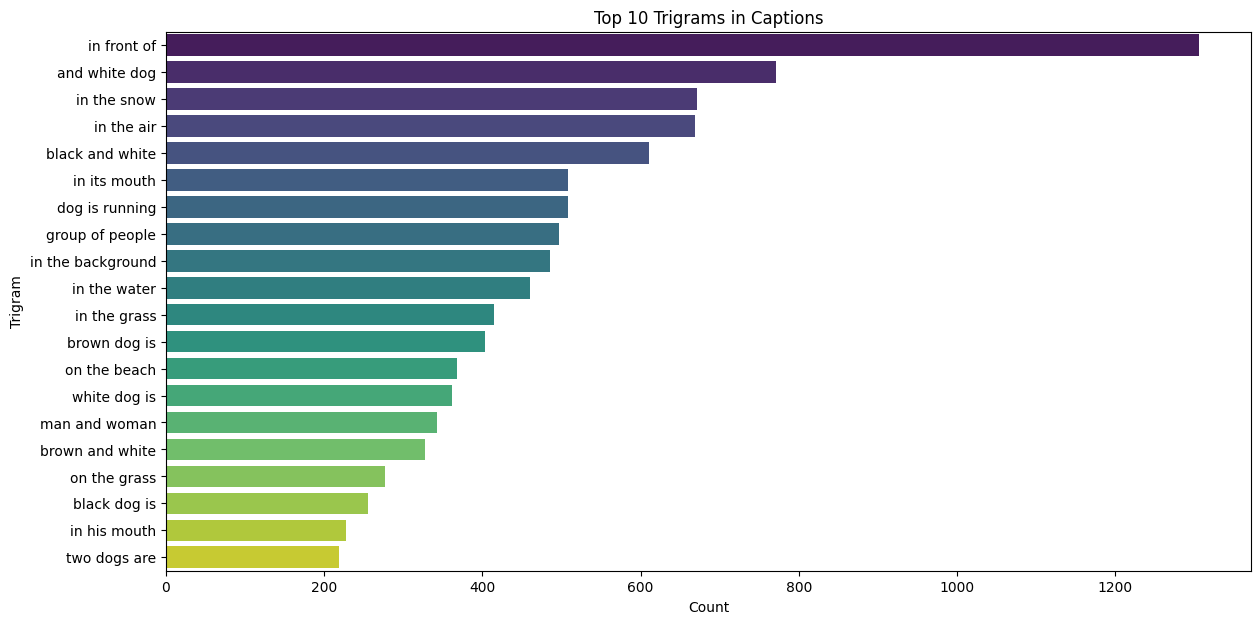

In [14]:
vectorizer = CountVectorizer(ngram_range=(3, 3))
Y = vectorizer.fit_transform(df_captions['caption'])

trigram_counts = Y.sum(axis=0).A1
trigram_features = vectorizer.get_feature_names_out()


trigram_dist = pd.DataFrame({'trigram': trigram_features, 'count': trigram_counts})
trigram_df = trigram_dist.sort_values(by='count', ascending=False).head(20)

plt.figure(figsize=(14, 7))
sns.barplot(x= 'count', y= 'trigram',data = trigram_df, palette='viridis', hue = 'trigram', legend = False)
plt.title('Top 10 Trigrams in Captions')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()

In [15]:
import albumentations as A

In [16]:
Augmentaion_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5)
    ])

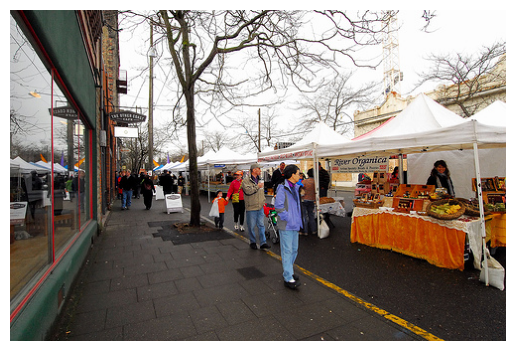

In [17]:
plt.imshow(cv2.cvtColor(cv2.imread(img_file_dir[4]),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [18]:
augmented_images = []
for img in img_file_dir:
  aug = Augmentaion_pipeline(image = cv2.imread(img))
  augmented_images.append(aug['image'])

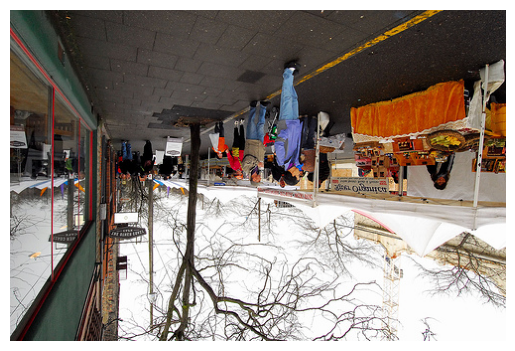

In [19]:
plt.imshow(cv2.cvtColor(augmented_images[4], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [20]:
img_count = 1
for i,img in enumerate(augmented_images):
  if os.path.exists(os.path.join('/content/drive/MyDrive/Flikr_dataset/aug_images',img_file_names[i])):
    continue
  cv2.imwrite(os.path.join('/content/drive/MyDrive/Flikr_dataset/aug_images',f'augmented_{img_file_names[i]}'), cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  img_count += 1
print(img_count)

8102


In [41]:
aug_image_name = []
aug_caption = []
for i,file in enumerate(img_file_names):
  aug_image_name.append(f'augmented_{file}')
  temp = df_captions[df_captions['image']==file]['caption']
  temp = temp.reset_index(drop=True)
  aug_caption.append(temp[0])

In [43]:
temp_df = pd.DataFrame({'image':aug_image_name,'caption':aug_caption})
temp_df.head()

,image,caption
0,augmented_382701159_f98c1988cd.jpg,a man fishes in the ocean .
1,augmented_3741827382_71e93298d0.jpg,a boy in a green shirt above something blue .
2,augmented_3730457171_e66dde8c91.jpg,a little girl rides a toy bike and laughs .
3,augmented_386470686_1ae9242878.jpg,a man crouched in the bare branches of a falle...
4,augmented_380515798_c2abbf46b0.jpg,a crowd walks along a sidewalk of a farmers ma...


In [44]:
df_captions = pd.concat([df_captions,temp_df])
len(df_captions)

48546

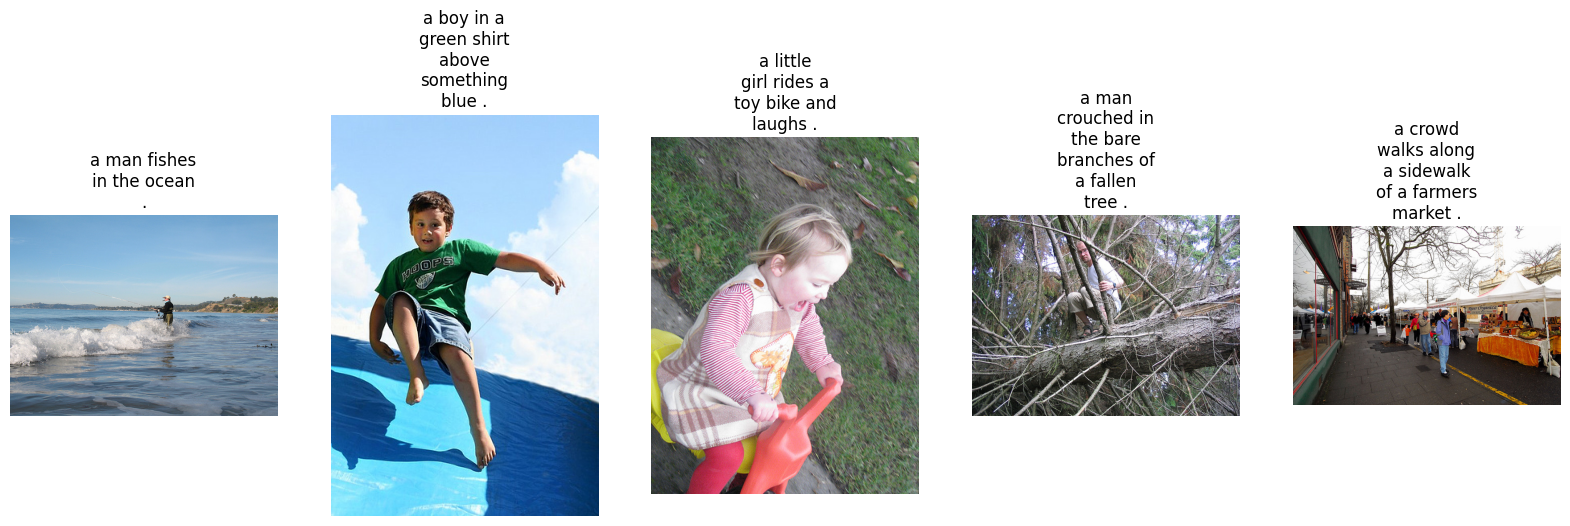

In [50]:
images = img_file_dir[:5]
plt.figure(figsize=(20, 20))
for i,file in enumerate(img_file_names[:5]):
  ax = plt.subplot(1, len(images), i + 1)
  caption = df_captions[df_captions['image']==file]['caption'].reset_index(drop=True)[0]
  caption = "\n".join(wrap(caption, 12))
  plt.title(caption)
  plt.imshow(cv2.cvtColor(cv2.imread(images[i]),cv2.COLOR_BGR2RGB))
  plt.axis("off")